In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

Loading dataset from hf


In [ ]:
from huggingface_hub import login
login("HF_TOKEN")


In [7]:


dataset = load_dataset("mbazaNLP/kinyarwanda_monolingual_v01.1", split="train")
print(dataset)
print(dataset[0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/276M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1068161 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'nr_words'],
    num_rows: 1068161
})
{'text': 'Rayon Sports yakoze imyitozo ikomeye yitegura Sunrise FC [AMAFOTO] Ikipe ya Rayon Sports ikomeje imyitozo ikomeye yitegura umukino w’umunsi wa 18 izakiramo Sunrise FC. Robertinho avuga ko atari umukino bazajenjekera kuko ngo ubu bamaze kwiha intego yo kwitwara neza kuri buri mukino, bagahatanira igikombe nta kujenjekera ikipe iyo ariyo yose. Mu gitondo cyo kuri uyu wa Kabiri, abakinnyi ba Rayon Sports bakoreye imyotozo muri ‘Gym’, nimugoroba bakorera imyitozo yindi mu Nzove. Ni imyitozo yitabiriwe n’abakinnyi bose kuko nta n’umwe ufite imvune uretse Tuyishime Eric Congolais uri gukorera imyitozo ku ruhande kubera imvune ye itarakira neza. Rayon Sports iri kwitegura Sunrise FC bagomba guhura kuri uyu wa Gatanu tariki 1 Werurwe 2019 kuri Stade ya Kigali i Nyamirambo. Umukino ubanza wabaye tariki 1 Ugushyingo 2018, Rayon Sports yari yatsinze Sunrise FC 2-1 mu mukino Caleb yahawe ikarita itukura nyuma yo gukub

In [8]:
dataset.shape

(1068161, 2)

In [9]:
print(dataset[0])
print(dataset[1])
print(dataset[10])

{'text': 'Rayon Sports yakoze imyitozo ikomeye yitegura Sunrise FC [AMAFOTO] Ikipe ya Rayon Sports ikomeje imyitozo ikomeye yitegura umukino w’umunsi wa 18 izakiramo Sunrise FC. Robertinho avuga ko atari umukino bazajenjekera kuko ngo ubu bamaze kwiha intego yo kwitwara neza kuri buri mukino, bagahatanira igikombe nta kujenjekera ikipe iyo ariyo yose. Mu gitondo cyo kuri uyu wa Kabiri, abakinnyi ba Rayon Sports bakoreye imyotozo muri ‘Gym’, nimugoroba bakorera imyitozo yindi mu Nzove. Ni imyitozo yitabiriwe n’abakinnyi bose kuko nta n’umwe ufite imvune uretse Tuyishime Eric Congolais uri gukorera imyitozo ku ruhande kubera imvune ye itarakira neza. Rayon Sports iri kwitegura Sunrise FC bagomba guhura kuri uyu wa Gatanu tariki 1 Werurwe 2019 kuri Stade ya Kigali i Nyamirambo. Umukino ubanza wabaye tariki 1 Ugushyingo 2018, Rayon Sports yari yatsinze Sunrise FC 2-1 mu mukino Caleb yahawe ikarita itukura nyuma yo gukubita umugeri umufana wari winjiye mu kibuga. Nyuma y’imyitozo, Robertinh

In [10]:
sample_text = dataset[0]['text']
sample_text

'Rayon Sports yakoze imyitozo ikomeye yitegura Sunrise FC [AMAFOTO] Ikipe ya Rayon Sports ikomeje imyitozo ikomeye yitegura umukino w’umunsi wa 18 izakiramo Sunrise FC. Robertinho avuga ko atari umukino bazajenjekera kuko ngo ubu bamaze kwiha intego yo kwitwara neza kuri buri mukino, bagahatanira igikombe nta kujenjekera ikipe iyo ariyo yose. Mu gitondo cyo kuri uyu wa Kabiri, abakinnyi ba Rayon Sports bakoreye imyotozo muri ‘Gym’, nimugoroba bakorera imyitozo yindi mu Nzove. Ni imyitozo yitabiriwe n’abakinnyi bose kuko nta n’umwe ufite imvune uretse Tuyishime Eric Congolais uri gukorera imyitozo ku ruhande kubera imvune ye itarakira neza. Rayon Sports iri kwitegura Sunrise FC bagomba guhura kuri uyu wa Gatanu tariki 1 Werurwe 2019 kuri Stade ya Kigali i Nyamirambo. Umukino ubanza wabaye tariki 1 Ugushyingo 2018, Rayon Sports yari yatsinze Sunrise FC 2-1 mu mukino Caleb yahawe ikarita itukura nyuma yo gukubita umugeri umufana wari winjiye mu kibuga. Nyuma y’imyitozo, Robertinho yaganir

Train a BPE Tokenizer from scratch

In [11]:
def train_bpe_tokenizer(dataset, vocab_size):
    tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
    tokenizer.normalizer = normalizers.NFKC()
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        min_frequency=2,
        special_tokens=["<s>", "<pad>", "</s>", "<unk>"]
    )

    def batch_iterator(batch_size=1000):
        for i in range(0, len(dataset), batch_size):
            yield dataset[i : i + batch_size]["text"]

    tokenizer.train_from_iterator(batch_iterator(), trainer=trainer)
    return tokenizer



In [12]:
tokenizer = train_bpe_tokenizer(dataset, vocab_size=32000)


In [13]:

sample_text = dataset[2]["text"]

encoding = tokenizer.encode(sample_text)

print("Original text:", sample_text[:200], "...\n")
print("Tokens:", encoding.tokens[:30])
print("IDs:", encoding.ids[:30])


Original text: Rwanda: Hatanzwe umurongo ku bibazo bya DRC. Leta y’u Rwanda mu itangazo yasohoye ku rubuga rwa interineti ibinyujije kuri Ministeri y’Ububanyi n’Amahanga, ejo ku wa 18 Gahyantare 2024 yashyize ahagar ...

Tokens: ['ĠRwanda', ':', 'ĠHa', 'tanzwe', 'Ġumurongo', 'Ġku', 'Ġbibazo', 'Ġbya', 'ĠDRC', '.', 'ĠLeta', 'Ġy', 'âĢĻ', 'u', 'ĠRwanda', 'Ġmu', 'Ġitangazo', 'Ġyasohoye', 'Ġku', 'Ġrubuga', 'Ġrwa', 'Ġinterineti', 'Ġibinyujije', 'Ġkuri', 'ĠMinisteri', 'Ġy', 'âĢĻ', 'Ububanyi', 'Ġn', 'âĢĻ']
IDs: [431, 29, 632, 2291, 2234, 224, 2525, 331, 9472, 17, 902, 302, 236, 88, 431, 226, 5313, 8754, 224, 3664, 502, 4632, 16964, 383, 16438, 302, 236, 7952, 212, 236]


In [14]:

save_path = "/content/drive/MyDrive/Colab Notebooks/Kinya gpt/2kinyarwanda_bpe_32k.json"
tokenizer.save(save_path)
print(f"Tokenizer saved at {save_path}")


Tokenizer saved at /content/drive/MyDrive/Colab Notebooks/Kinya gpt/2kinyarwanda_bpe_32k.json


In [15]:


tok_path = "/content/drive/MyDrive/Colab Notebooks/Kinya gpt/2kinyarwanda_bpe_32k.json"
tokenizer = Tokenizer.from_file(tok_path)


dataset = dataset


all_ids = []
for text in dataset["text"]:
    ids = tokenizer.encode(text).ids
    all_ids.extend(ids + [tokenizer.token_to_id("</s>")])

print(f"Total tokens: {len(all_ids):,}")

all_ids = np.array(all_ids, dtype=np.int32)


split_idx = int(0.9 * len(all_ids))
train_ids = all_ids[:split_idx]
val_ids = all_ids[split_idx:]

print(f"Train tokens: {len(train_ids):,}")
print(f"Val tokens: {len(val_ids):,}")



Total tokens: 93,285,123
Train tokens: 83,956,610
Val tokens: 9,328,513


Creating chunks

In [16]:
block_size = 512

def create_blocks(data, block_size):

    n_blocks = len(data) // block_size
    data = data[:n_blocks * block_size]
    data = data.reshape(n_blocks, block_size)
    return data

train_blocks = create_blocks(train_ids, block_size)
val_blocks   = create_blocks(val_ids, block_size)

In [17]:
train_blocks

array([[ 1661,  1531,  2356, ..., 21624,  1661,  1531],
       [   17,   978,   656, ..., 17888,  7981,   321],
       [28909,  4505, 18943, ...,   392, 16261,   327],
       ...,
       [ 3002,  4652,   502, ...,    15, 15377,  4346],
       [ 1159, 21125,    15, ...,  1901,   401,   598],
       [ 8318,   546,    29, ...,   546,    29,   465]], dtype=int32)

In [18]:
val_blocks

array([[  236, 11833,  6753, ..., 14143,    17,   939],
       [  250,  5143,   217, ...,  1401,  3200,  5164],
       [15771,  5415,    29, ...,  2271,   472,  3720],
       ...,
       [14835,   243,  1898, ...,   245,  1889,   637],
       [25918, 17789, 28349, ...,  2949,  3913,   309],
       [  502,  5669,    17, ...,  3697,  6366,    17]], dtype=int32)

In [19]:
decoded_text = tokenizer.decode(train_blocks[1].tolist())
decoded_text.replace("Ġ", " ")



'.  Ati  "  Ni  umukinnyi  mwiza ,  ni  umukinnyi  uzi  gutsinda  kandi  ukunda  gukora .  Ni  umukinnyi  wihuta  cyane  ,  azadufasha .  Bwa  mbere  Rayon  Sports  yashyikirijwe  umusaruro  wa  mbere  wavuye  mu  bakiriya  ba  Radi ant  Nyuma  y âĢĻ amezi  abiri  y âĢĻ ubufatanye  hagati  ya  Sosiyete  y âĢĻ ubwishingizi  ya  Radi ant  ndetse  na  Rayon  Sports ,  umusaruro  wa  mbere  wa shyikirijwe  Rayon  Sports  Ni  mu  birori  by âĢĻ ubusa bane  no  kuganira  ku  masezerano  y âĢĻ ubufatanye  ari  hagati  ya  Rayon  Sports  na  Radi ant ,  byabereye  muri  Serena  Hotel  bihuza  abayobozi  ba  Radi ant ,  abayobozi  ba  Rayon  Sports ,  abi geze  kuyobora  Rayon  Sports ,  ndetse  n âĢĻ abayobozi  b âĢĻ amatsinda  y âĢĻ abafana .  Umuyobozi  wa  Sosiyete  ya  Radi ant  Marc  Ru genera  hamwe  n âĢĻ abakinnyi  ba  Rayon  Sports  Muri  ibi  birori ,  abayobozi  ba  Radi ant  bafashe  umwanya  wo  gusobanurira  abakunzi  ba  Rayon  Sports  ibijyanye  n âĢĻ ubwishingizi  bashobora  g

Dataset & Dataloaders x and y

In [20]:
from torch.utils.data import DataLoader, TensorDataset

def make_dataset(data):
    x = data[:, :-1]
    y = data[:, 1:]
    return TensorDataset(torch.from_numpy(x), torch.from_numpy(y))

train_dataset = make_dataset(train_blocks)
val_dataset   = make_dataset(val_blocks)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)

In [21]:
x, y = next(iter(train_loader))
x, y

(tensor([[  955,    34,   660,  ..., 15951, 24590,  2422],
         [ 1418,  9657,   245,  ...,    17,  4836,    15],
         [  368,   341,  1103,  ...,  8298,   226,  5094],
         ...,
         [ 1262, 20293,    76,  ...,  1263,   321,   518],
         [20329, 11905,   277,  ...,  6524,   208,    10],
         [  233,  3650, 29828,  ...,   662,  3294,   664]], dtype=torch.int32),
 tensor([[   34,   660,  8712,  ..., 24590,  2422,   226],
         [ 9657,   245, 25064,  ...,  4836,    15, 15665],
         [  341,  1103,  2306,  ...,   226,  5094, 25061],
         ...,
         [20293,    76,   817,  ...,   321,   518,   243],
         [11905,   277,  1320,  ...,   208,    10, 25994],
         [ 3650, 29828,    15,  ...,  3294,   664,   272]], dtype=torch.int32))

Training GPT from Scratch

In [22]:
class GPTConfig:
    vocab_size = 32000
    block_size = 512
    n_embd = 512
    n_layer = 6
    n_head = 8
    dropout = 0.1


Model

In [23]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb   = nn.Embedding(config.block_size, config.n_embd)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.n_embd,
            nhead=config.n_head,
            dim_feedforward=4 * config.n_embd,
            activation="gelu",
            batch_first=True,
            dropout=config.dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=config.n_layer)

        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.drop = nn.Dropout(config.dropout)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.config.block_size, "Sequence too long!"

        tok_emb = self.token_emb(idx)
        pos_emb = self.pos_emb(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb

        x = self.drop(x)

        mask = torch.triu(torch.ones(T, T, device=idx.device), diagonal=1).bool()
        x = self.transformer(x, mask=mask)

        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1)
            )

        return logits, loss


Training Loop

In [24]:
train_losses = []
val_losses = []

device = "cuda" if torch.cuda.is_available() else "cpu"
config = GPTConfig()
model = GPT(config).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

num_epochs = 8
save_dir = "/content/drive/MyDrive/Colab Notebooks/Kinya_gpt/"

print("Training...")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device).long()

        optimizer.zero_grad()
        _, loss = model(x, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            avg_loss_so_far = total_loss / (batch_idx + 1)
            print(f"Epoch {epoch+1} | Step {batch_idx+1}/{len(train_loader)} | Avg Train Loss: {avg_loss_so_far:.4f}")

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device).long()
            _, loss = model(x, y)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")





Training...
Epoch 1 | Step 100/5125 | Avg Train Loss: 8.1940
Epoch 1 | Step 200/5125 | Avg Train Loss: 7.8031
Epoch 1 | Step 300/5125 | Avg Train Loss: 7.5507
Epoch 1 | Step 400/5125 | Avg Train Loss: 7.3543
Epoch 1 | Step 500/5125 | Avg Train Loss: 7.1923
Epoch 1 | Step 600/5125 | Avg Train Loss: 7.0527
Epoch 1 | Step 700/5125 | Avg Train Loss: 6.9349
Epoch 1 | Step 800/5125 | Avg Train Loss: 6.8314
Epoch 1 | Step 900/5125 | Avg Train Loss: 6.7395
Epoch 1 | Step 1000/5125 | Avg Train Loss: 6.6569
Epoch 1 | Step 1100/5125 | Avg Train Loss: 6.5821
Epoch 1 | Step 1200/5125 | Avg Train Loss: 6.5138
Epoch 1 | Step 1300/5125 | Avg Train Loss: 6.4512
Epoch 1 | Step 1400/5125 | Avg Train Loss: 6.3921
Epoch 1 | Step 1500/5125 | Avg Train Loss: 6.3369
Epoch 1 | Step 1600/5125 | Avg Train Loss: 6.2859
Epoch 1 | Step 1700/5125 | Avg Train Loss: 6.2373
Epoch 1 | Step 1800/5125 | Avg Train Loss: 6.1921
Epoch 1 | Step 1900/5125 | Avg Train Loss: 6.1496
Epoch 1 | Step 2000/5125 | Avg Train Loss: 6.10

RuntimeError: Parent directory /content/drive/MyDrive/Colab Notebooks/Kinya_gpt does not exist.

In [26]:

save_dir = "/content/drive/MyDrive/Colab Notebooks/Kinya gpt/"
final_path = save_dir + f"2KinyaMiniGpt{num_epochs}.pt"
torch.save({
    "epoch": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "train_loss": train_losses[-1],
    "val_loss": val_losses[-1],
}, final_path)
print(f"Model Saved in {final_path}")

Model Saved in /content/drive/MyDrive/Colab Notebooks/Kinya gpt/2KinyaMiniGpt8.pt


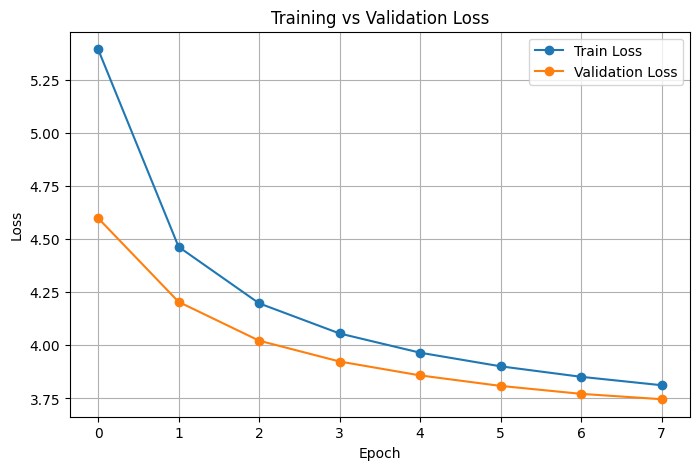

In [27]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [28]:

def evaluate_model(model, val_loader, device="cuda"):
    model.eval()
    total_loss = 0
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device).long()
            logits, loss = model(x, y)
            total_loss += loss.item()


            preds = torch.argmax(logits, dim=-1)
            mask = y != -100
            correct += (preds[mask] == y[mask]).sum().item()
            total   += mask.sum().item()

    avg_loss = total_loss / len(val_loader)
    perplexity = math.exp(avg_loss)
    accuracy = correct / total

    return avg_loss, perplexity, accuracy


val_loss, val_ppl, val_acc = evaluate_model(model, val_loader, device)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Perplexity: {val_ppl:.2f}")
print(f"Validation Accuracy: {val_acc*100:.2f}%")


Validation Loss: 3.7463
Validation Perplexity: 42.36
Validation Accuracy: 33.44%


In [29]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

config = GPTConfig()
model = GPT(config).to(device)


model_path = "/content/drive/MyDrive/Colab Notebooks/Kinya gpt/2KinyaMiniGpt8.pt"




load_model = torch.load(model_path, map_location=device)
model.load_state_dict(load_model["model_state_dict"])




<All keys matched successfully>

In [30]:

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params:,}")


Total trainable parameters: 51,945,472


In [31]:


def generate_text(model, tokenizer, prompt, max_new_tokens=50, temperature=1.2, top_k=50):
    model.eval()
    device = next(model.parameters()).device


    input_ids = tokenizer.encode(prompt).ids
    input_ids = torch.tensor([input_ids], dtype=torch.long, device=device)

    for _ in range(max_new_tokens):

        logits, _ = model(input_ids)
        logits = logits[:, -1, :] / temperature


        if top_k is not None:
            values, indices = torch.topk(logits, k=top_k)
            probs = torch.zeros_like(logits).scatter_(1, indices, values)
            probs = F.softmax(probs, dim=-1)
        else:
            probs = F.softmax(logits, dim=-1)


        next_id = torch.multinomial(probs, num_samples=1)
        input_ids = torch.cat([input_ids, next_id], dim=1)


    output_text = tokenizer.decode(input_ids[0].tolist(), skip_special_tokens=True)
    return output_text


In [33]:

tok_path = "/content/drive/MyDrive/Colab Notebooks/Kinya gpt/2kinyarwanda_bpe_32k.json"
tokenizer = Tokenizer.from_file(tok_path)


In [44]:
prompt = "Amakuru y'umunsi"
generated = generate_text(model, tokenizer, prompt, max_new_tokens=50, temperature=0.9)
print("Generated text:\n", generated.replace("Ġ", " "))


Generated text:
  Amakuru  y ' umunsi  ku  wundi ,  aho  abantu  benshi  baba  bara sobanukiwe  iby ' uyu  mukino  ndetse  na  Perezida  Kagame  yagize  ati :" Iki  ni  cyo  gihe  tuzaba menyesha  ko  iyi  mikino  iza kinwa  mu  ntangiriro  z ' uyu  mwaka "  , yagan  nubwitonzi ,  tuzi banda  ku  gukora  siporo  n ' ibindi


In [38]:
sd_hf = model.state_dict()
for k, v in sd_hf.items():
  print(k, v.shape)

token_emb.weight torch.Size([32000, 512])
pos_emb.weight torch.Size([512, 512])
transformer.layers.0.self_attn.in_proj_weight torch.Size([1536, 512])
transformer.layers.0.self_attn.in_proj_bias torch.Size([1536])
transformer.layers.0.self_attn.out_proj.weight torch.Size([512, 512])
transformer.layers.0.self_attn.out_proj.bias torch.Size([512])
transformer.layers.0.linear1.weight torch.Size([2048, 512])
transformer.layers.0.linear1.bias torch.Size([2048])
transformer.layers.0.linear2.weight torch.Size([512, 2048])
transformer.layers.0.linear2.bias torch.Size([512])
transformer.layers.0.norm1.weight torch.Size([512])
transformer.layers.0.norm1.bias torch.Size([512])
transformer.layers.0.norm2.weight torch.Size([512])
transformer.layers.0.norm2.bias torch.Size([512])
transformer.layers.1.self_attn.in_proj_weight torch.Size([1536, 512])
transformer.layers.1.self_attn.in_proj_bias torch.Size([1536])
transformer.layers.1.self_attn.out_proj.weight torch.Size([512, 512])
transformer.layers.1.s